### Calculations and plotting for Figure S4

#### import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import cartopy.crs as ccrs

In [2]:
import importlib
from project_utils import fig_utils as figu

importlib.reload(figu)

<module 'project_utils.fig_utils' from '/oak/stanford/groups/omramom/group_members/fvdav/projects/precip_clustering/project_utils/fig_utils.py'>

In [3]:
## set plot configurations
figu.set_plt_rc_params()

#### Read GHCN data

In [4]:
ghcn_dat = pd.read_csv("../processed_data/ghcn_midwest_data.csv",
                       dtype = {'ID': 'string', 'DATE': 'int64',
                        'DATA_VALUE': 'float64', 'LATITUDE': 'float64', 'LONGITUDE': 'float64'})

In [5]:
station_IDs = np.unique(ghcn_dat.ID)

In [6]:
ghcn_dat['date'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d").dt.date.astype('string')
ghcn_dat['year'] = pd.to_datetime(ghcn_dat['DATE'], format = "%Y%m%d").dt.year

#### Read class predictions

In [7]:
class_prob = pd.read_csv("../processed_data/predicted_class_data.csv")

In [8]:
ghcn_dat = ghcn_dat.join(class_prob.set_index("date")[["predicted_class", "prob_1"]], 
                         on = "date", how = "left")

In [9]:
epcp_dates = class_prob.loc[class_prob.predicted_class == 1].date
non_epcp_dates = class_prob.loc[class_prob.predicted_class == 0].date

In [10]:
p95_thr = ghcn_dat.DATA_VALUE.groupby(ghcn_dat.ID).quantile(0.95).reset_index().rename(
          columns = {"DATA_VALUE": "p95"})

In [11]:
ghcn_dat = ghcn_dat.join(p95_thr.set_index("ID"), on = "ID", how = "left")

In [12]:
ghcn_dat['extreme'] = np.where(ghcn_dat.DATA_VALUE >= ghcn_dat.p95, 1, 0)

#### Calculate "regional" performance:

In [13]:
sta_per_day = ghcn_dat.groupby('date').extreme.count().reset_index().rename(columns={"extreme":"total_stations"})

In [14]:
extreme_per_day = ghcn_dat.groupby('date').extreme.sum().reset_index().rename(columns={"extreme":"extreme_stations"})

In [15]:
region_df = class_prob.join(sta_per_day.set_index("date"), on = "date", how = "left"
                    ).join(extreme_per_day.set_index("date"), on = "date", how = "left")

In [16]:
region_df['frac_extreme'] = region_df.extreme_stations/region_df.total_stations
region_df['frac_binary'] = np.where(region_df.frac_extreme >= 0.2, 1, 0)

#### Calculate performance at each station:

In [17]:
import sklearn.metrics

In [18]:
ghcn_recall = []
ghcn_auc = []
ghcn_accuracy = []

for sta in station_IDs:
    df = ghcn_dat.loc[ghcn_dat.ID == sta]
    ghcn_recall.append(sklearn.metrics.recall_score(df.extreme, df.predicted_class))
    ghcn_accuracy.append(sklearn.metrics.accuracy_score(df.extreme, df.predicted_class))
    ghcn_auc.append(sklearn.metrics.roc_auc_score(df.extreme, df.prob_1))

In [19]:
result_df = pd.DataFrame({"ID": station_IDs, "recall": ghcn_recall, "auc": ghcn_auc, "accuracy": ghcn_accuracy})

In [20]:
result_df = result_df.join(ghcn_dat[["ID", "LONGITUDE", "LATITUDE"]].drop_duplicates().set_index("ID"), 
                                 on = "ID", how = "left")

### Figure S4: 

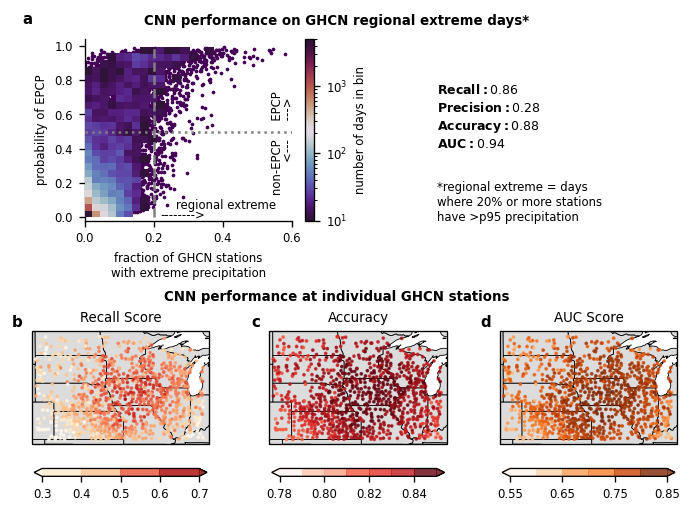

In [21]:
fig = plt.figure(figsize = (6, 4.2))

ax = fig.add_axes([0.15, 0.57, 0.36, 0.36])
i = (region_df.frac_extreme > 0) & (region_df.prob_1 > 0.02)
ax.scatter(region_df.loc[i, "frac_extreme"], region_df.loc[i, "prob_1"], 
           color = figu.fig2c_col, s = 1.5, zorder = 0)
p = ax.hist2d(region_df.frac_extreme, region_df.prob_1, bins = 25, cmin = 10, 
          norm = matplotlib.colors.LogNorm(), zorder = 5, cmap = figu.fig2c_cmap);
ax.vlines(0.2, 0, 1, linestyle = "dashed", color = "gray", zorder = 10, linewidth = 1.5)
ax.hlines(0.5, 0, 1, linestyle = "dotted", color = "gray", zorder = 10, linewidth = 1.5)
ax.set(ylabel = "probability of EPCP", xlabel = "fraction of GHCN stations\nwith extreme precipitation", ylim = (-0.02, 1.04), 
       xlim=(0, 0.6))
cbar = plt.colorbar(p[3], label = "number of days in bin");
figu.format_plot(ax)
ax.text(0.54, 0.51, s = "non-EPCP     EPCP       ", va = "center", 
        size = 7, zorder = 30, rotation = "vertical")
ax.text(0.57, 0.51, s = "<---     --->", va = "center", 
        size = 7, zorder = 30, rotation = "vertical")
ax.text(0.22, -0.01, s = "-------->", 
        size = 7, zorder = 30)
ax.text(0.22, 0.05, s = "    regional extreme", 
        size = 7, zorder = 30)
figu.add_panel_label(ax, "a", x = -0.25)

fig.suptitle("CNN performance on GHCN regional extreme days*", weight = "bold")

ax.text(x = 1.7, y = 0.7, s = r"$\bf{Recall: }$" + 
        str(np.round(sklearn.metrics.recall_score(region_df.frac_binary, region_df.predicted_class), 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.7, y = 0.6, s = r"$\bf{Precision: }$" +
        str(np.round(sklearn.metrics.precision_score(region_df.frac_binary, region_df.predicted_class), 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.7, y = 0.5, s = r"$\bf{Accuracy: }$" +
        str(np.round(sklearn.metrics.accuracy_score(region_df.frac_binary, region_df.predicted_class), 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.7, y = 0.4, s = r"$\bf{AUC: }$" +
        str(np.round(sklearn.metrics.roc_auc_score(region_df.frac_binary, region_df.prob_1), 2)), size = 7.5,
       transform=ax.transAxes)
ax.text(x = 1.7, y = 0, s = "*regional extreme = days\nwhere 20% or more stations\nhave >p95 precipitation", size = 7, 
       transform=ax.transAxes)


ax = fig.add_axes([0.05, 0.03, 0.3, 0.32], projection = ccrs.PlateCarree())
p = ax.scatter(result_df.LONGITUDE, result_df.LATITUDE, c=result_df.recall, cmap = figu.orangered, 
               vmin = 0.3, vmax = 0.7, s = 1.5, alpha = 0.8, 
               zorder = 10)
ax.set(title='Recall Score')
figu.format_ghcn_map(ax)
figu.add_panel_label(ax, "b", x = -0.05)
fig.colorbar(p, shrink = 0.8, extend = "both", location = "bottom", 
            boundaries = np.arange(0.2, 0.9, 0.1))

ax = fig.add_axes([0.38, 0.03, 0.3, 0.32], projection = ccrs.PlateCarree())
p = ax.scatter(result_df.LONGITUDE, result_df.LATITUDE, c=result_df.accuracy, cmap = figu.reds, 
               vmin = 0.78, vmax = 0.85, s = 1.5, alpha = 0.8, 
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='Accuracy')
figu.add_panel_label(ax, "c", x = -0.05)
fig.colorbar(p, shrink = 0.8, extend = "both", location = "bottom", 
            boundaries = np.arange(0.77, 0.87, 0.01), 
            ticks = np.arange(0.78, 0.87, 0.02))

ax = fig.add_axes([0.7, 0.03, 0.3, 0.32], projection = ccrs.PlateCarree())
p = ax.scatter(result_df.LONGITUDE, result_df.LATITUDE, c=result_df.auc, cmap = figu.oranges, 
               vmin = 0.55, vmax = 0.85, s = 1.5, alpha = 0.8, 
               zorder = 10)
figu.format_ghcn_map(ax)
ax.set(title='AUC Score')
figu.add_panel_label(ax, "d", x = -0.05)
fig.colorbar(p, shrink = 0.8, extend = "both", location = "bottom", 
            boundaries = np.arange(0.5, 0.95, 0.05), 
            ticks = np.arange(0.55, 0.95, 0.1))

ax.text(x = 0.5, y = 0.41, s = "CNN performance at individual GHCN stations", 
        weight = "bold", size = 8, ha = "center", 
       transform = fig.transFigure)

fig.savefig("../figures/figure_S4.pdf")